In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyximport
import h5py
import time

pyximport.install(setup_args={'include_dirs': np.get_include()},reload_support=True)
from RigidWall_InertialLangevin3D_cython import RigidWallInertialLangevin3D

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit

import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
#rc('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')

In [2]:
class HDF5Store(object):
    """
    Simple class to append value to a hdf5 file on disc (usefull for building keras datasets)
    
    Params:
        datapath: filepath of h5 file
        dataset: dataset name within the file
        shape: dataset shape (not counting main/batch axis)
        dtype: numpy dtype
    
    Usage:
        hdf5_store = HDF5Store('/tmp/hdf5_store.h5','X', shape=(20,20,3))
        x = np.random.random(hdf5_store.shape)
        hdf5_store.append(x)
        hdf5_store.append(x)
        
    From https://gist.github.com/wassname/a0a75f133831eed1113d052c67cf8633
    """
    def __init__(self, datapath, dataset, shape, dtype=np.float64, compression="gzip", chunk_len=1):
        self.datapath = datapath
        self.dataset = dataset
        self.shape = shape
        self.i = 0
        
        with h5py.File(self.datapath, mode='w') as h5f:
            self.dset = h5f.create_dataset(
                dataset,
                shape=(0, ) + shape,
                maxshape=(None, ) + shape,
                dtype=dtype,
                compression=compression,
                chunks=(chunk_len, ) + shape)
    
    def append(self, values):
        with h5py.File(self.datapath, mode='a') as h5f:
            dset = h5f[self.dataset]
            dset.resize((self.i + 1, ) + self.shape)
            dset[self.i] = [values]
            self.i += 1
            h5f.flush()

# Langevin 3D Inertial close rigid wall

Voici la partie du code qui cacule la position $x_i$ tel que :

\begin{equation}
    x_i = x_{i-1} + ( - \Delta m g + R_{elec} + F_{correction} ) \frac{\Delta t}{\gamma (z)} + a(\gamma (z)) * dB_t * \Delta t
\end{equation}

<font color='blue'> 
    J'avais des problème au niveau de la PDF, en tatonant pour voir ce qui ne va pas, j'ai remarqué que c'est le poids qui n'allait pas. </font>
<font color='blue'>     
    Comme ci-dessous, j'ai divisé le poids $\Delta m g$ par deux et dans ce cas, la PDF est quasi parfaite (voir cellule 7). </font>
<font color='blue'>     
    Par contre la MSD (cellule 11) ne va plus trop entre la théorique (calculé avec le coef de diffusion moyen) et la MSD numérique. Le facteur 1/2 décale les MSD théoriques des MSD numérique. C'est étrange ...</font>


if axis == "z":

    gamma = self._gamma_z(zi_1) # Pade formula
    weight = self.delta_m * self.g * self.dt / (gamma) / 2
    elec = (
            (4 * self.kb * self.T)
            / (self.lD)
            * np.exp(-zi_1 / self.lD)
            * self.dt
            / gamma
           )
    correction = (
                  self.kb
                  * self.T
                  * (42 * self.R * zi_1 ** 2 + 24 * self.R ** 2 * zi_1 + 4 *                        self.R ** 3)
                  / ((6 * zi_1 ** 2 + 9 * self.R * zi_1 + 2 * self.R ** 2)**2 )
                  * self.dt
                  / gamma
                 )


else:

    gamma = self._gamma_xy(zi_1) # Libchaber formula
    elec = 0
    weight = 0
    correction = 0

xi = xi_1 - weight + elec + correction + self._a(gamma) * rng * self.dt

if axis == "z":

    if xi <= 0:
    xi = -xi

In [6]:
tps1 = time.time()
langevin3D = RigidWallInertialLangevin3D(dt=1e-6, Nt=1000000, R=1.5e-6, rho=1050, x0=(0., 0., 1.5e-6))
langevin3D.trajectory()
tps2 = time.time()
    
time_calcul = tps2 - tps1

In [7]:
time_calcul

0.7874898910522461

In [4]:
# traj = langevin3D.x, langevin3D.y, langevin3D.z

# store = HDF5Store("Datas_inertial_RIgidWall\data1.h5", "data1", shape = np.shape(traj))

In [5]:
# %timeit store.append(traj)

In [6]:
# store2 = HDF5Store("Datas_inertial_RIgidWall\data2.h5", "data1", shape = np.shape(traj), compression = None)

# %timeit store2.append(traj)

## 1. Trajectory

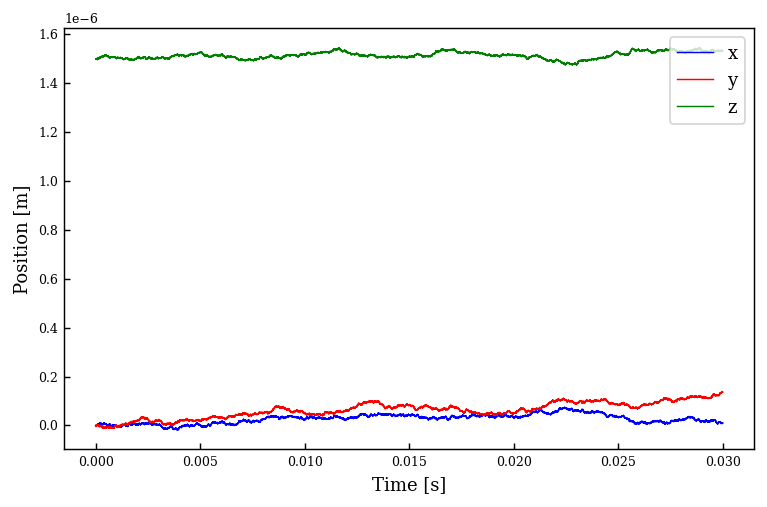

In [7]:
langevin3D.plotTrajectory()

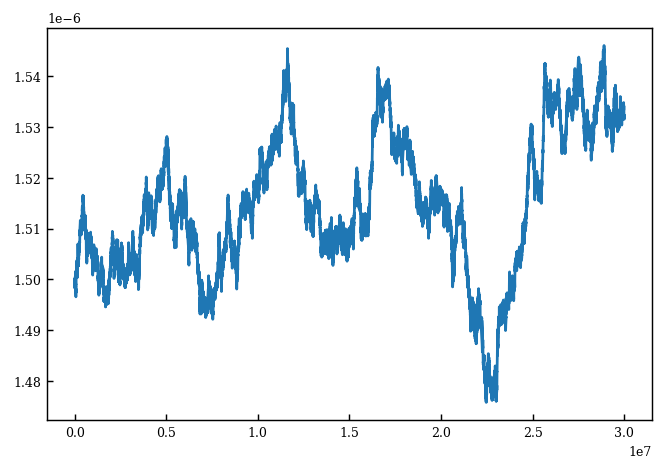

In [8]:
plt.plot(langevin3D.z)

## 2. Mean square displacement

In [9]:
MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

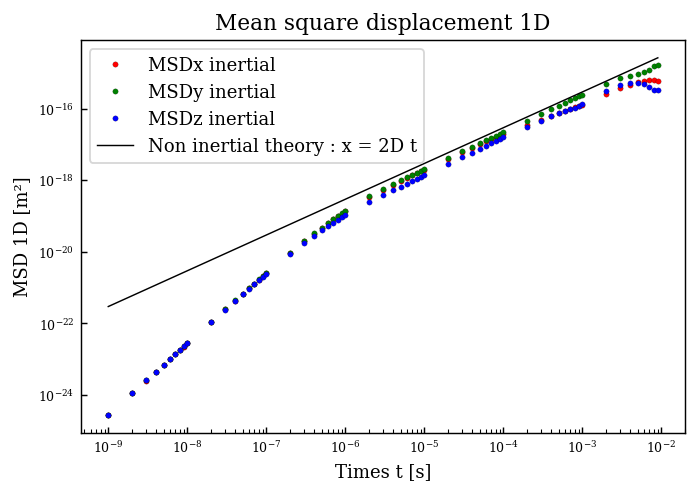

In [10]:
fig1 = plt.figure()
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    ".",
    color="red",
    label="MSDx inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
    ".",
    color="green",
    label="MSDy inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    ".",
    color="blue",
    label="MSDz inertial",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma)
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="black",
    linewidth=0.8,
    label="Non inertial theory : x = 2D t",
)
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend()
plt.show()

## 3. Probability density function of z

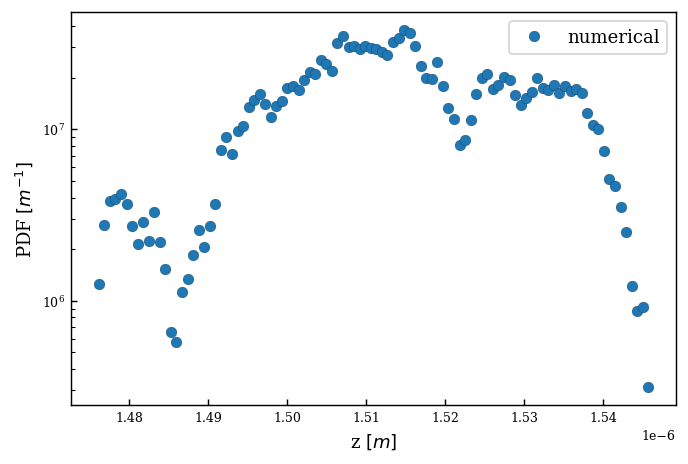

In [11]:
axis = "z"
bins = 100
hist, bin_edges = np.histogram(langevin3D.z, bins=bins, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf = hist * 1/np.trapz(hist,binsPosition)

# x_theo = np.linspace(0, 3e-6, 1000)
x_theo = binsPosition

pdf_theo = np.exp( -(4) * np.exp(- x_theo/langevin3D.lD) - x_theo/langevin3D.lB)
pdf_theo = pdf_theo * 1/np.trapz(pdf_theo,x_theo) # normalised

# pdf_theo_brut = np.exp( -(4) * np.exp(- x_theo/langevin3D.lD) - x_theo/langevin3D.lB)
# pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,x_theo) # normalised

plt.semilogy(binsPosition,pdf, "o", label="numerical")
# plt.semilogy(x_theo, pdf_theo, "-", label="theory")

plt.xlabel(axis + " $[m]$")
plt.ylabel("PDF $[m^{-1}]$")
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
plt.show()

## 4. Mesure average of diffusion coeficient

In [12]:
# ----- On Z --------- !
# Diffusion coef
Dz = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_z(binsPosition))
# function to integrate
f_theo = Dz * pdf_theo
# Theoritical diffusion coef
mean_D_theo = np.trapz(f_theo,binsPosition)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_D_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

# -------- On X ----------- !
Dx = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_xy(binsPosition))
fx_theo = Dx * pdf_theo
mean_Dx_theo = np.trapz(fx_theo,binsPosition)
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

<Dz>_theo/D_0 = 0.47
<Dx>_theo/D_0 = 0.7198784451


In [13]:
Do = langevin3D.kb * langevin3D.T / langevin3D.gamma
mean_gamma_xy = 1/(mean_Dx_theo/(langevin3D.kb*langevin3D.T))
mean_gamma_z = 1/(mean_D_theo/(langevin3D.kb*langevin3D.T))

mean_tau_x = langevin3D.m/mean_gamma_xy
mean_tau_z = langevin3D.m/mean_gamma_z

mean_tau_x, mean_tau_z

(3.77936183686019e-07, 2.479149641260465e-07)

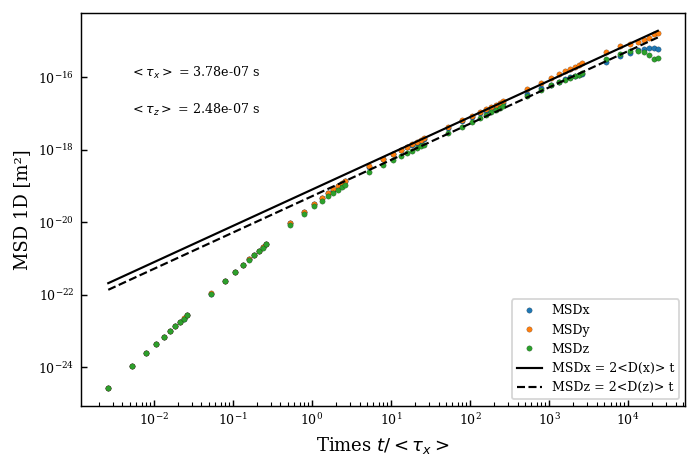

In [14]:
fig1 = plt.figure()

plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x,
    MSDx,
    ".",
    label="MSDx",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x,
    MSDy,
    ".",
    label="MSDy",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    MSDz,
    ".",
    label="MSDz",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    2*mean_Dx_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    "-",
    color="black",
    linewidth=1.2,
    label="MSDx = 2<D(x)> t",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    2*mean_D_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    "--",
    color="black",
    linewidth=1.2,
    label="MSDz = 2<D(z)> t",
)

plt.text(5e-3, 1e-16, "$<\\tau_x>$ = {:.2e} s".format(mean_tau_x), fontsize=7)
plt.text(5e-3, 1e-17, "$<\\tau_z>$ = {:.2e} s".format(mean_tau_z), fontsize=7)
plt.xlabel("Times $t/ <\\tau_{x}> $")
plt.ylabel("MSD 1D [m²]")
# plt.axis([1e-3, 1e3, None, None])

plt.legend(loc='lower right', fontsize="x-small")
plt.show()

In [15]:
mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)

0.7198784451162268

In [16]:
print("<Tau_x>_theo = {:.10e}".format(langevin3D.m/mean_gamma_xy))
print("<Tau_z>_theo = {:.10e}".format(langevin3D.m/mean_gamma_z))

<Tau_x>_theo = 3.7793618369e-07
<Tau_z>_theo = 2.4791496413e-07


In [17]:
def lin_func(x, a):
    return (a*x)
def monome_func(x, a, b):
    return (a*x**b)

# Mesure de pentes des droite de la MSDz
i_tau = np.argmax(MSDz>1e-20)
x = langevin3D.t[langevin3D.list_dt_MSD[i_tau:-10]]/mean_tau_x
y = MSDz[i_tau:-10]
popt_msdz_diff, pcov_msdz_diff = curve_fit(lin_func, x, y)
x_fit_diff = np.linspace(0, np.max(langevin3D.t[langevin3D.list_dt_MSD]), 10000)/mean_tau_x
MSDz_fit_diff = lin_func(x_fit_diff, *popt_msdz_diff)

# Mesure de pentes des droite de la MSDx

x = langevin3D.t[langevin3D.list_dt_MSD[:i_tau]]/mean_tau_x
y = MSDz[:i_tau]
popt_msdz_inertia, pcov_msdz_inertia = curve_fit(monome_func, x, y, p0=(4e-13, 2))
x_fit_inertia = np.linspace(0, np.max(langevin3D.t[langevin3D.list_dt_MSD]), 10000)/mean_tau_x
MSDz_fit_inertia = monome_func(x_fit_inertia, *popt_msdz_inertia)

MSDz_fit_inertia

array([0.00000000e+00, 1.39453170e-19, 5.00619646e-19, ...,
       3.31073814e-12, 3.31134883e-12, 3.31195957e-12])

In [1]:
fig1 = plt.figure()

# plt.loglog(
#     langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x,
#     MSDx,
#     ".",
#     label="MSDx",
# )
# plt.loglog(
#     langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x,
#     MSDy,
#     ".",
#     label="MSDy",
# )
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    MSDz,
    "o",
    label="MSDz",
# )
# plt.plot(
#     x_fit_diff,
#     MSDz_fit_diff,
#     "-",
#     label="Fit diffusion regime"
# )
# plt.plot(
#     x_fit_inertia,
#     MSDz_fit_inertia,
#     "-",
#     label="Fit inertial regime"
# )

plt.text(5e-3, 1e-16, "$<\\tau_x>$ = {:.2e} s".format(mean_tau_x), fontsize=7)
plt.text(5e-3, 1e-17, "$<\\tau_z>$ = {:.2e} s".format(mean_tau_z), fontsize=7)
plt.xlabel("Times $t/ <\\tau_{x}> $")
plt.ylabel("MSD 1D [m²]")
# plt.axis([1e-3, 1e3, None, None])

plt.legend(loc='lower right', fontsize="x-small")
plt.show()

print("Fit diffusion = {:.2e} ".format(*popt_msdz_diff))
print("Fit inertial = {:.2e}, {:.2e} ".format(*popt_msdz_inertia))

SyntaxError: invalid syntax (<ipython-input-1-ea6dd2605e27>, line 35)

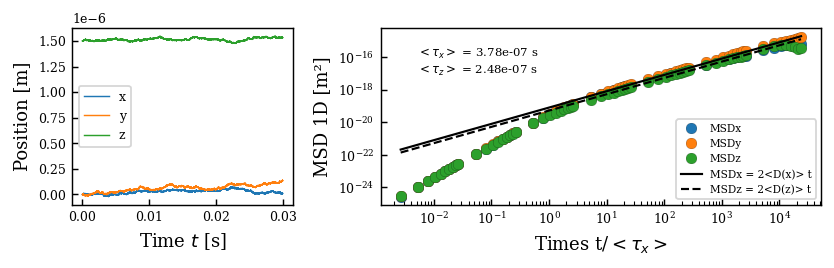

In [19]:
def cm2Inch(cm):
    inch = cm / 2.54
    return inch

w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)
fig = plt.figure(constrained_layout=True, figsize=(w,h/2))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

###################################################
fig.add_subplot(spec[0, 0])

plt.plot(langevin3D.t, langevin3D.x, linewidth=0.8, label="x")
plt.plot(langevin3D.t, langevin3D.y, linewidth=0.8, label="y")
plt.plot(langevin3D.t, langevin3D.z, linewidth=0.8, label="z")
plt.xlabel("Time $t$ [s]")
plt.ylabel("Position [m]")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
plt.legend(loc="center left", fontsize="x-small")

###################################################
fig.add_subplot(spec[0, 1:])


plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x,
    MSDx,
    "o",
    label="MSDx",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x,
    MSDy,
    "o",
    label="MSDy",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    MSDz,
    "o",
    label="MSDz",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    2*mean_Dx_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    "-",
    color="black",
    linewidth=1.2,
    label="MSDx = 2<D(x)> t",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD]/mean_tau_x ,
    2*mean_D_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    "--",
    color="black",
    linewidth=1.2,
    label="MSDz = 2<D(z)> t",
)

plt.text(5e-3, 1e-16, "$<\\tau_x>$ = {:.2e} s".format(mean_tau_x), fontsize=6.5)
plt.text(5e-3, 1e-17, "$<\\tau_z>$ = {:.2e} s".format(mean_tau_z), fontsize=6.5)
plt.xlabel("Times t/$ <\\tau_{x}> $")
plt.ylabel("MSD 1D [m²]")
# plt.axis([1e-3, 1e3, None, None])

plt.legend(loc='lower right', fontsize="xx-small")